In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall7'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3276.34 seconds 
duration: 0.91 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Buffer of 0.25 added before/after each epoch
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.art_epochs.npy saved
Total artifact time = 53.8 seconds


,start,stop,label,duration
0,59.2892,60.1268,,0.8376
1,95.6828,96.2564,,0.5736
2,109.8076,130.4188,,20.6112
3,152.9348,155.1932,,2.2584
4,1388.1052,1397.4324,,9.3272
5,1418.4500,1420.2988,,1.8488
6,1442.4684,1443.4660,,0.9976
7,2581.0348,2588.1916,,7.1568
8,2594.1204,2602.5948,,8.4744
9,2870.6188,2871.4828,,0.8640


<Axes: >

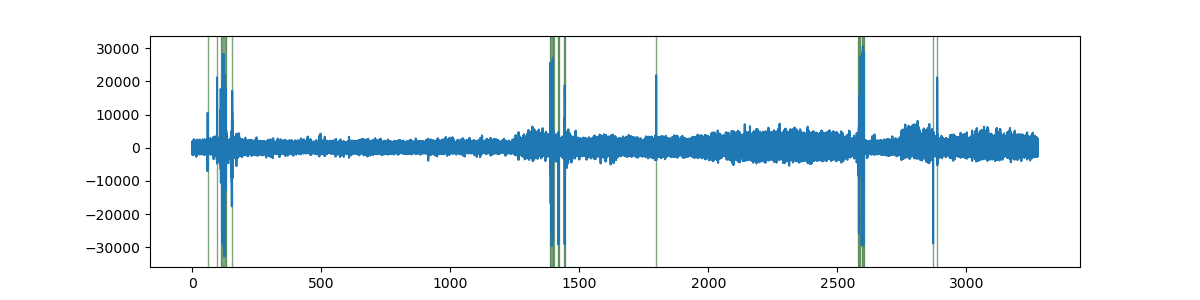

In [11]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

In [ ]:
### Code below to modify epochs manually if necessary

In [ ]:
# # Delete art epochs between certain times
# t1 = [156, 317, 336, 64*60 + 27, 65*60 +13]
# t2 = [165, 328, 343, 64*60 + 40, 65*60 +21]
# for tstart, tstop in zip(t1, t2):
#     art_epochs = art_epochs.delete_in_between(t1=tstart, t2=tstop)

# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs.save(art_epochs_file)

In [ ]:
# Add in epochs manually after inspection in neuroscope - then re-run above to check!

# individual epoch
# t1 = 10767.3
# t2 = 10768.7
# art_epochs = art_epochs.add_epoch_manually(t1, t2)

# List of epochs
# epochs_to_add =np.array([[1400.5, 1401.0], [3736, 3739]])
# art_epochs = art_epochs.add_epoch_manually(epochs_to_add[:, 0], epochs_to_add[:, 1])
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs.save(art_epochs_file)

# Finn training has some issues too.
lots of false negative AND positive SWRs, likely due to weird thresholds from noisy epochs.  Get more aggressive with artifact removal?

### Code below to import updated epochs after manual adjustment in Neuroscope!

In [9]:
# Note that Neuroscope is super buggy with adding events to existing files! One tactic is to create an .ar2 file and then add 
# in any adjustments then merge.

art_epochs_ns = sess.recinfo.event_to_epochs(evt_file=sess.filePrefix.with_suffix('.evt.ar2'))
art_epochs_ns

5 epochs
Snippet: 
        start       stop label
0   109.7552   130.7870      
1  1399.9544  1400.3936      
2  1418.0348  1420.3324      
3  1797.5042  1798.0026      
4  2594.0680  2602.8086      

In [10]:
# Merge files and export!
art_epochs_merge = art_epochs.__add__(art_epochs_ns).merge(0)
art_epochs_merge.save(art_epochs_file)
art_epochs = art_epochs_merge
sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
art_epochs

/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.art_epochs.npy saved


13 epochs
Snippet: 
        start       stop label
0    59.2892    60.1268  None
1    95.6828    96.2564  None
2   109.7552   130.7870  None
3   152.9348   155.1932  None
4  1388.1052  1397.4324  None

## Define probe group

/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.probegroup.npy saved


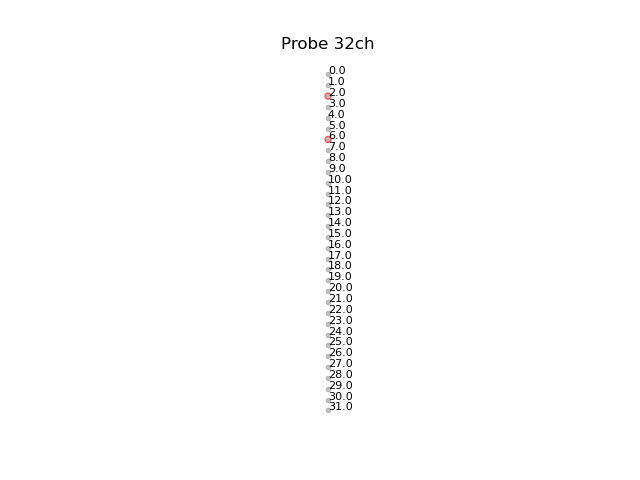

In [12]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [40]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 20

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [20]
269 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [16]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 26
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [26]
1903 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.ripple_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [41]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

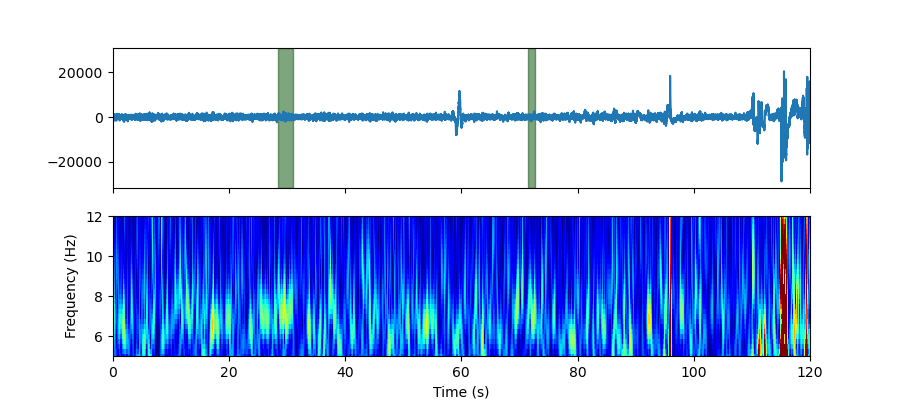

In [42]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [267 268] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

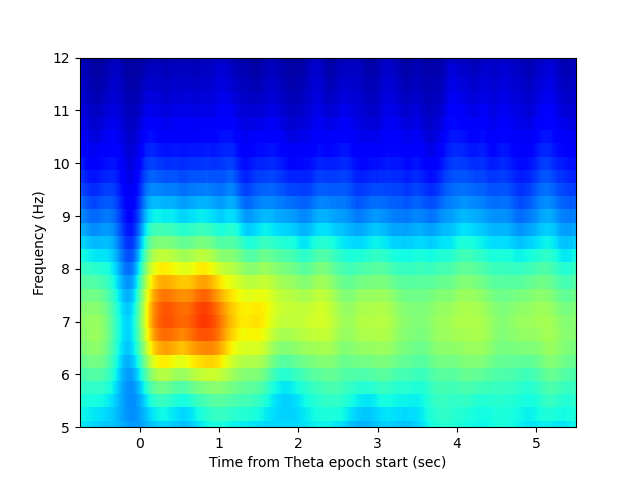

In [43]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [35]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

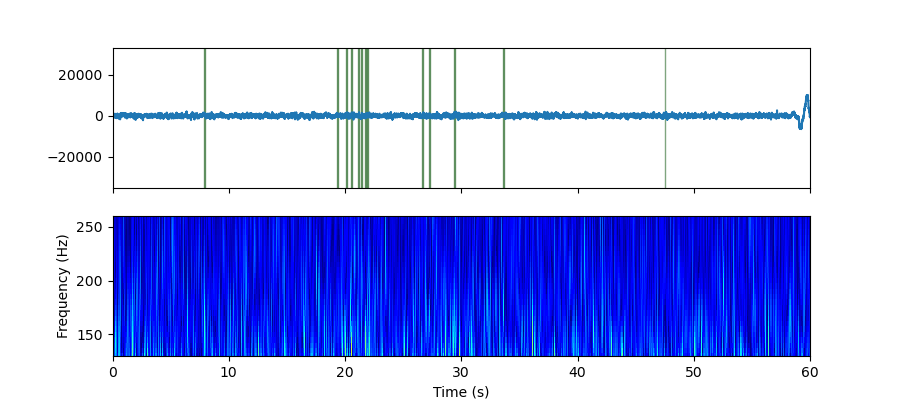

In [36]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

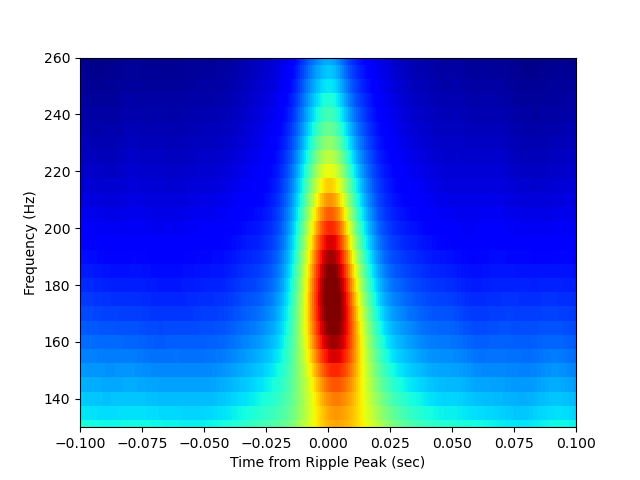

In [37]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
0,-2,1352647,2022-01-27 12:35:23.088233333,
301,2,5020097,2022-01-27 12:37:25.336566667,
302,-2,5317738,2022-01-27 12:37:35.257933333,
1099,2,7298096,2022-01-27 12:38:41.269866667,
1248,-2,7596231,2022-01-27 12:38:51.207700000,


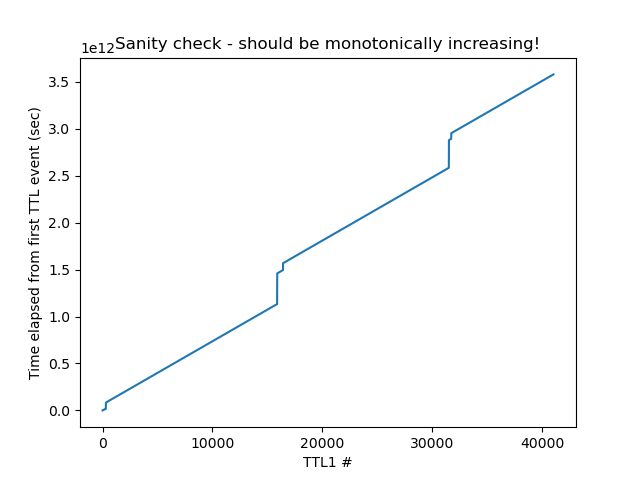

In [24]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [25]:
import tracefc.io.traceio as traceio

process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
if sess_name.find("recall") == 0:
    # For tone recall CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} tone recall')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} control tone recall')
    print(csn_starts.head(6))
    
    # For CS+ at end of control_tone_recall
    cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
    print(cs2_starts.head(6))
elif sess_name.find("habituation") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    process_cs, process_cs2 = False, False
    
elif sess_name.find("training") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    # For training CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} training')
    print(cs_starts.head(6))

    process_cs2 = False
    

15 CS+ events detected during recall7 tone recall
      Time (s)      Event                     Timestamp
5    61.013983  CS1_start 2022-01-27 12:37:25.471877488
7   136.946709  CS2_start 2022-01-27 12:38:41.404603394
9   197.893818  CS3_start 2022-01-27 12:39:42.351712378
11  277.847069  CS4_start 2022-01-27 12:41:02.304963263
13  352.776171  CS5_start 2022-01-27 12:42:17.234065446
15  426.725596  CS6_start 2022-01-27 12:43:31.183489951
12 CS- events detected during recall7 control tone recall
      Time (s)      Event                     Timestamp
5    60.837843  CS1_start 2022-01-27 13:01:39.919239703
7   121.761522  CS2_start 2022-01-27 13:02:40.842919293
9   189.712134  CS3_start 2022-01-27 13:03:48.793531123
11  250.660771  CS4_start 2022-01-27 13:04:49.742167655
13  316.591643  CS5_start 2022-01-27 13:05:55.673039857
15  390.543099  CS6_start 2022-01-27 13:07:09.624495688
3 CS+ events detected during recall7 control tone recall
       Time (s)           Event                    

In [26]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-27 12:34:38.161110-05:00
start time = 2022-01-27 12:58:32.342074-05:00
start time = 2022-01-27 13:23:32.483697-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-01-27 12:34:38.161110-05:00,start,0,0.000000,0,0.0000
1,0,2022-01-27 12:55:30.606943333-05:00,stop,37573375,1252.445833,1565557,1252.4456
2,1,2022-01-27 12:58:32.342074-05:00,start,37573376,1252.445867,1565558,1252.4464
3,1,2022-01-27 13:19:37.263640667-05:00,stop,75521023,2517.367433,3146709,2517.3672
4,2,2022-01-27 13:23:32.483697-05:00,start,75521024,2517.367467,3146710,2517.3680
5,2,2022-01-27 13:36:11.455397-05:00,stop,98290175,3276.339167,4095423,3276.3384


In [27]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(2, unit="seconds")

# CS+
if process_cs:
    cs_oe_start_df, cs_start_diff = traceio.trace_ttl_to_openephys(cs_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use, return_diff=True)
    # Convert to times in combined eeg file
    cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

    cs_oe_stop_df, cs_stop_diff = traceio.trace_ttl_to_openephys(cs_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use, return_diff=True)
    # Convert to times in combined eeg file
    cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

    # Export to neuroscope
    cs_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs_epochs, ext="csp")

    # Save to neuropy
    cs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
    cs_epochs.save(cs_file)


# CS-
csn_oe_start_df, csn_start_diff = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)    

csn_oe_stop_df, csn_stop_diff = traceio.trace_ttl_to_openephys(csn_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2, return_diff=True)

# Convert to times in combined eeg file
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

# Export to neuroscope
csn_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ""})
sess.recinfo.write_epochs(csn_epochs, ext="csn")

# Save to neuropy
csn_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
csn_epochs.save(csn_file)


# CS+ 2
if process_cs2:
    cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

    cs2_oe_stop_df = traceio.trace_ttl_to_openephys(cs2_ends, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_stops_combined = oeio.recording_events_to_combined_time(cs2_oe_stop_df, sync_df)

    # Export to neuroscope
    cs2_epochs = Epoch({"start": cs2_starts_combined, "stop": cs2_stops_combined, "label": ""})
    sess.recinfo.write_epochs(cs2_epochs, ext="cs2")

    # Save to neuropy
    cs2_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
    cs2_epochs.save(cs2_file)
    

# Quality control checks - print # epochs exported - should match numbers in cells above!
print("")  # blank line for readibility
if process_cs:
    print(f"{cs_oe_start_df.shape[0]} CS+ epochs saved")
print(f"{csn_oe_start_df.shape[0]} CS- epochs saved")
if process_cs2:
    print(f"{cs2_oe_start_df.shape[0]} CS+(2) epochs saved")

start time lag: mean = -0.1332605618, std = 0.0018417276616603869
start time lag: mean = -0.13471772326666667, std = 0.0008691793650008896
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.cs_epochs.npy saved
start time lag: mean = -0.31276219850000003, std = 0.0005560237039939796
start time lag: mean = -0.3138286249166667, std = 0.0005487869747588704
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.csn_epochs.npy saved
start time lag: mean = -0.31166691399999996, std = 0.00023240432791149913
start time lag: mean = -0.3126924643333333, std = 0.00013229735386745874
/data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.cs2_epochs.npy saved

15 CS+ epochs saved
12 CS- epochs saved
3 CS+(2) epochs saved


## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

1247 frames between 1442.5 and 1443.5 ignored (sent to nan)
623 frames between 1797.5 and 1798.0 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

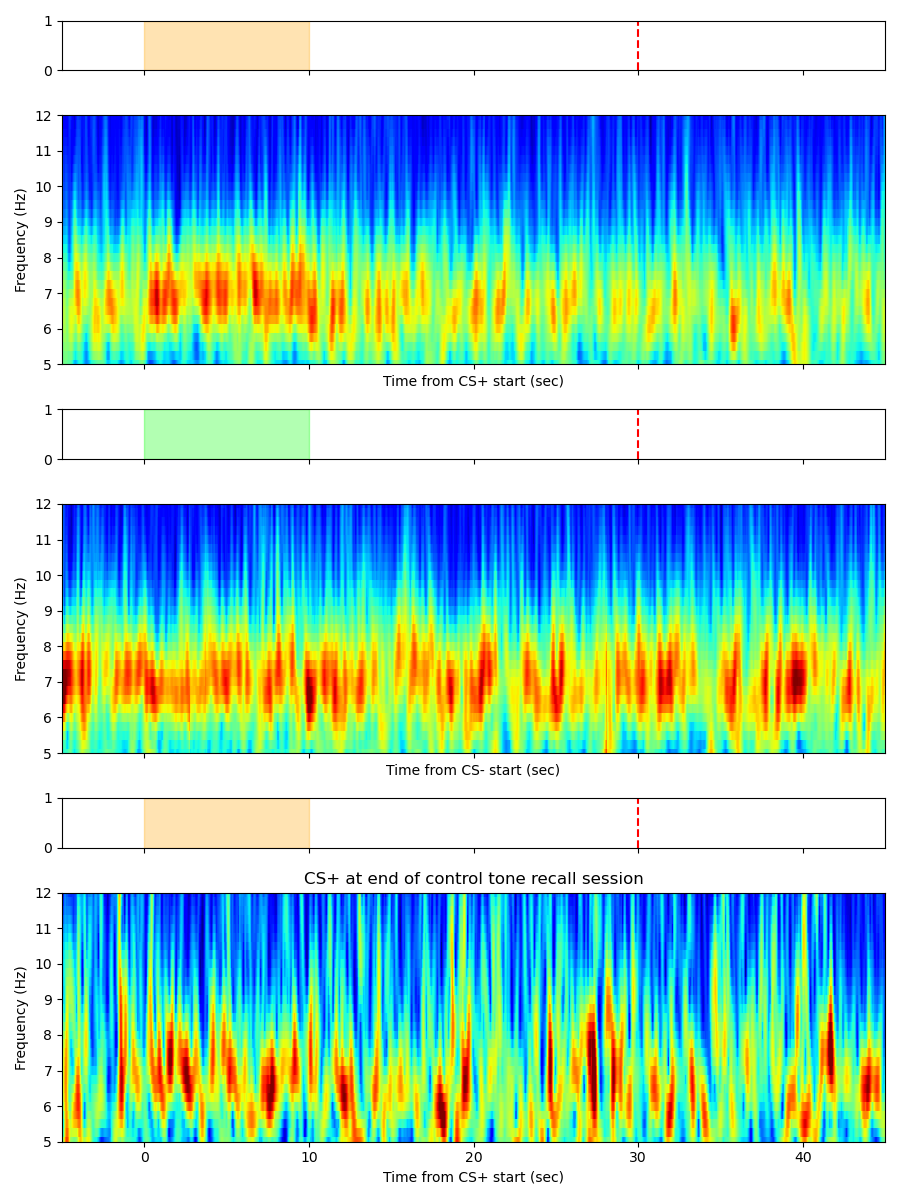

In [44]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

if sess_name.find("training") == 0: # for training sessions
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])

    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)

    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Ripple mean spectrogram

/tmp/ipykernel_2218094/2120224013.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

1247 frames between 1442.5 and 1443.5 ignored (sent to nan)
623 frames between 1797.5 and 1798.0 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

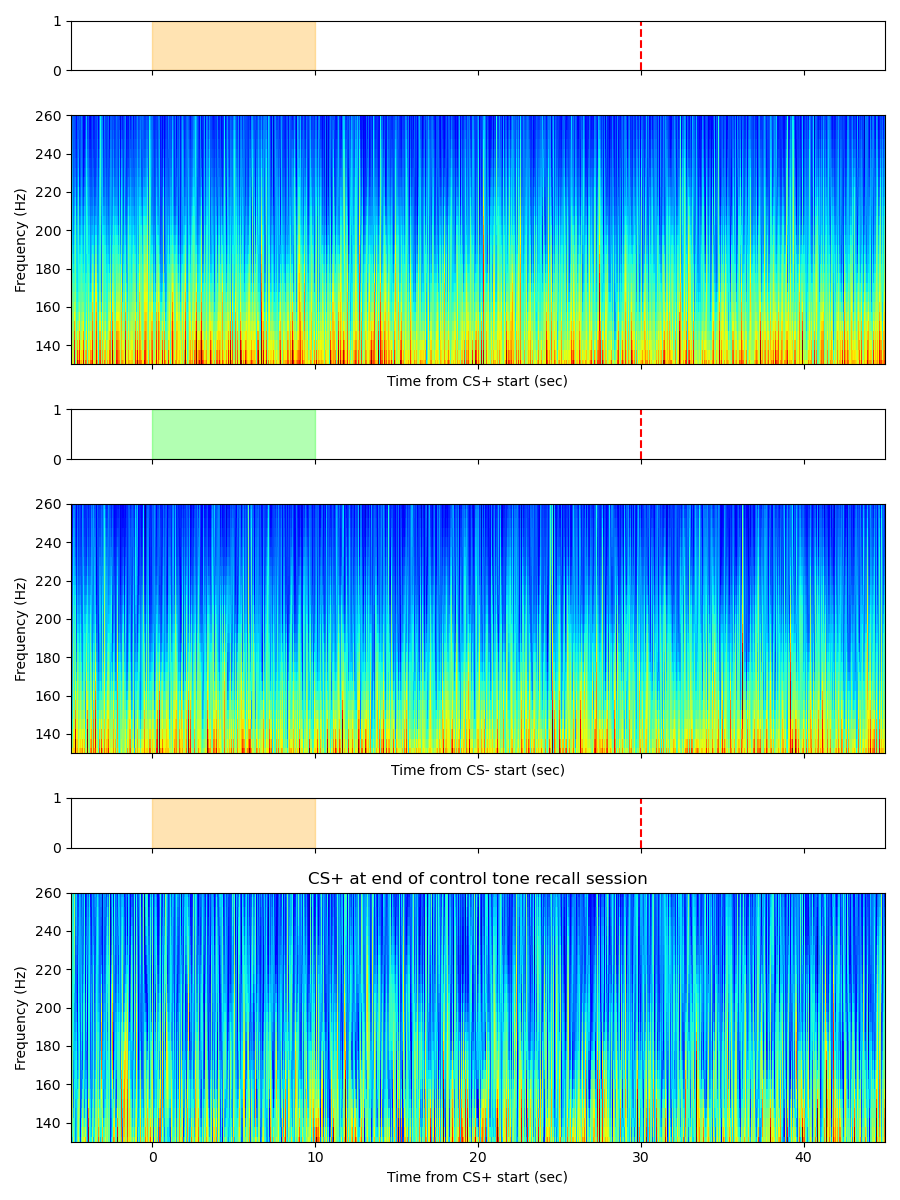

In [45]:
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

elif sess_name.find("training") == 0:
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [46]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data2/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_Spectral_Analysis.ipynb
